# NHS Referral-to-Treatment (RTT) Wait Times Analysis
*Dataset: February 2025 NHS RTT Data Extract*

### Project Goals

- Explore NHS RTT wait times for all patients.
- Identify outlier Trusts with excess long-waiters.
- Compare mean wait times across NHS providers.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Load the dataset (filename must match the file in your repo)
df = pd.read_csv('NHSwaitingtimes.csv')

# Clean up column names
df.columns = df.columns.str.strip().str.replace('\n', '', regex=False).str.replace('\t', '', regex=False)

# Display basic info
print(df.shape)
print(df.columns[:15])  # Show first 15 columns for reference
df.head(2)


(184268, 121)
Index(['Period', 'Provider Parent Org Code', 'Provider Parent Name',
       'Provider Org Code', 'Provider Org Name',
       'Commissioner Parent Org Code', 'Commissioner Parent Name',
       'Commissioner Org Code', 'Commissioner Org Name', 'RTT Part Type',
       'RTT Part Description', 'Treatment Function Code',
       'Treatment Function Name', 'Gt 00 To 01 Weeks SUM 1',
       'Gt 01 To 02 Weeks SUM 1'],
      dtype='object')


,Period,Provider Parent Org Code,Provider Parent Name,Provider Org Code,Provider Org Name,Commissioner Parent Org Code,Commissioner Parent Name,Commissioner Org Code,Commissioner Org Name,RTT Part Type,...,Gt 98 To 99 Weeks SUM 1,Gt 99 To 100 Weeks SUM 1,Gt 100 To 101 Weeks SUM 1,Gt 101 To 102 Weeks SUM 1,Gt 102 To 103 Weeks SUM 1,Gt 103 To 104 Weeks SUM 1,Gt 104 Weeks SUM 1,Total,Patients with unknown clock start date,Total All
0,RTT-February-2025,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,A4M8P,BUCKSHAW HOSPITAL,NaN,NaN,13Q,NATIONAL COMMISSIONING HUB 1,Part_2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1
1,RTT-February-2025,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,A4M8P,BUCKSHAW HOSPITAL,NaN,NaN,13Q,NATIONAL COMMISSIONING HUB 1,Part_2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2


## Wait Time Columns

We'll focus on columns containing 'Weeks' and 'SUM 1' in their names.


In [2]:
wait_cols = [col for col in df.columns if 'Weeks' in col and 'SUM 1' in col]
df_waits = df[wait_cols]
df_waits.head()


,Gt 00 To 01 Weeks SUM 1,Gt 01 To 02 Weeks SUM 1,Gt 02 To 03 Weeks SUM 1,Gt 03 To 04 Weeks SUM 1,Gt 04 To 05 Weeks SUM 1,Gt 05 To 06 Weeks SUM 1,Gt 06 To 07 Weeks SUM 1,Gt 07 To 08 Weeks SUM 1,Gt 08 To 09 Weeks SUM 1,Gt 09 To 10 Weeks SUM 1,...,Gt 95 To 96 Weeks SUM 1,Gt 96 To 97 Weeks SUM 1,Gt 97 To 98 Weeks SUM 1,Gt 98 To 99 Weeks SUM 1,Gt 99 To 100 Weeks SUM 1,Gt 100 To 101 Weeks SUM 1,Gt 101 To 102 Weeks SUM 1,Gt 102 To 103 Weeks SUM 1,Gt 103 To 104 Weeks SUM 1,Gt 104 Weeks SUM 1
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


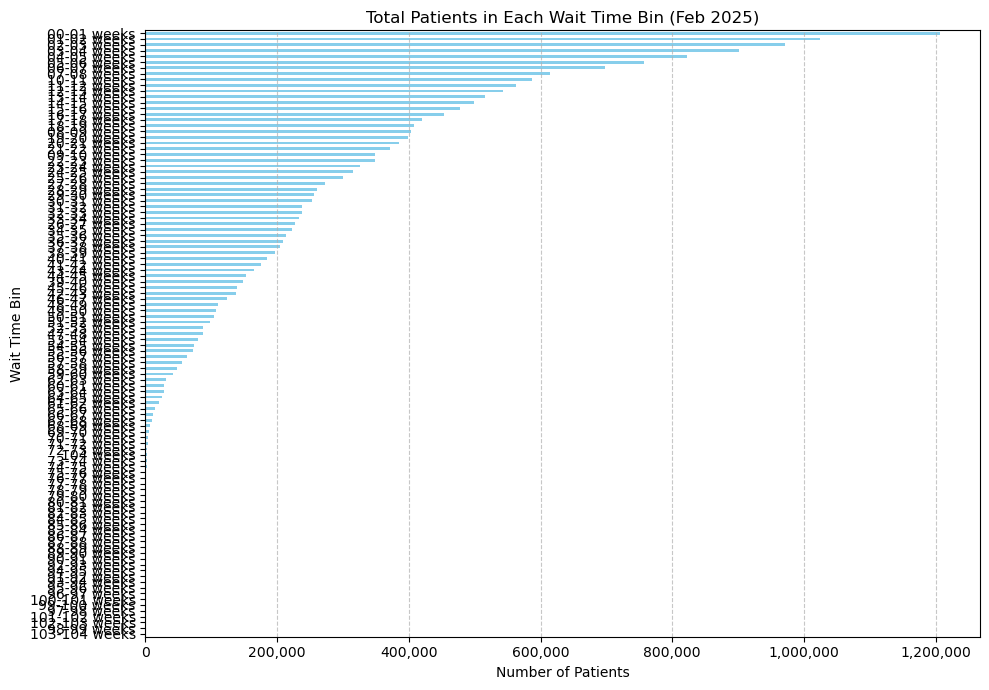

In [3]:
# Sum up all patient counts for each wait bin across the dataset
wait_sums = df_waits.sum()
wait_sums = wait_sums[wait_sums > 0]  # Filter empty bins

# Clean up y-axis labels
def clean_label(label):
    if 'Gt ' in label and 'Weeks' in label:
        core = label.split('Gt ')[1].split(' Weeks')[0].replace(' To ', '-')
        return f"{core} weeks"
    elif 'Gt ' in label and 'Weeks' in label and 'To' not in label:
        num = label.split('Gt ')[1].split(' Weeks')[0]
        return f"{num}+ weeks"
    else:
        return label

wait_sums.index = [clean_label(lbl) for lbl in wait_sums.index]
wait_sums = wait_sums.sort_values()

# Plot
plt.figure(figsize=(10, 7))
wait_sums.plot(kind='barh', color='skyblue')
plt.title('Total Patients in Each Wait Time Bin (Feb 2025)')
plt.xlabel('Number of Patients')
plt.ylabel('Wait Time Bin')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Improving Readability

The initial plot shows all wait time bins, but many have very few or zero patients, making the chart crowded and hard to interpret.  
To make the visual more informative, we filter to only display bins with a significant number of patients (>1,000). This focuses attention on the bins that matter most for NHS performance and makes the trends much clearer.


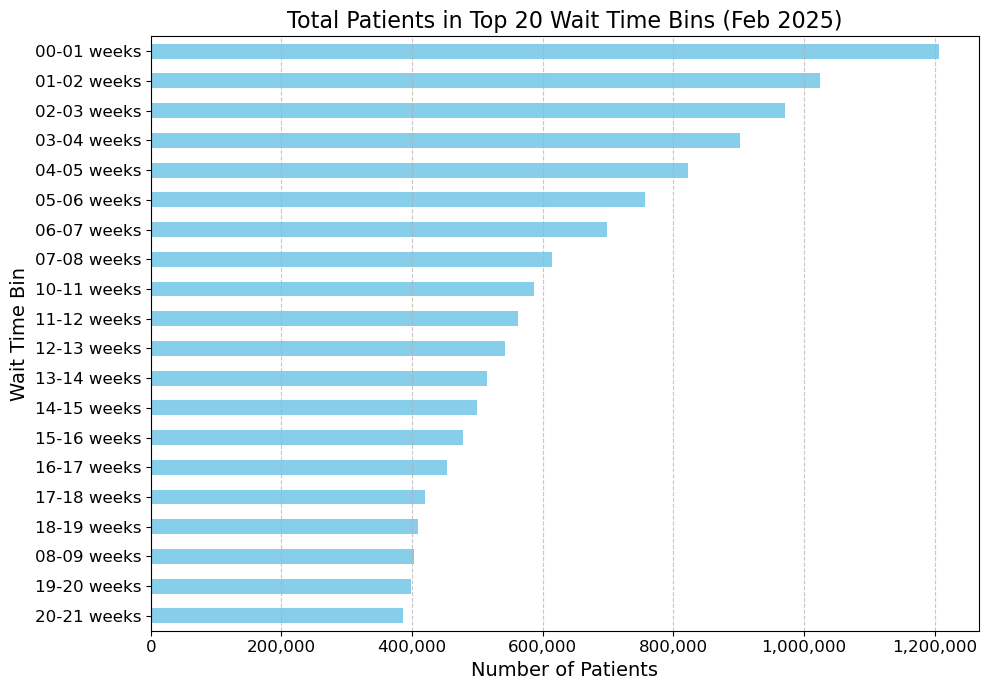

In [4]:
# Filter and plot only the most relevant wait time bins
filtered_wait_sums = wait_sums[wait_sums > 1000]
filtered_wait_sums = filtered_wait_sums.sort_values(ascending=False).head(20).sort_values()

plt.figure(figsize=(10, 7))
filtered_wait_sums.plot(kind='barh', color='skyblue')
plt.title('Total Patients in Top 20 Wait Time Bins (Feb 2025)', fontsize=16)
plt.xlabel('Number of Patients', fontsize=14)
plt.ylabel('Wait Time Bin', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Proportion of Patients Waiting Over 21 Weeks

To visualize the distribution of wait times, we split patients into two groups:
- Those waiting **21 weeks or less**
- Those waiting **over 21 weeks**

Because the NHS dataset bins very long waits into fewer, larger groups, our “>21 weeks” category includes all available columns for longer waits (even if there are large gaps between bins).


In [5]:
# List all columns that represent week bins (ends with 'Weeks SUM 1')
wait_bins = [col for col in df.columns if 'Weeks SUM 1' in col]
print(wait_bins)


['Gt 00 To 01 Weeks SUM 1', 'Gt 01 To 02 Weeks SUM 1', 'Gt 02 To 03 Weeks SUM 1', 'Gt 03 To 04 Weeks SUM 1', 'Gt 04 To 05 Weeks SUM 1', 'Gt 05 To 06 Weeks SUM 1', 'Gt 06 To 07 Weeks SUM 1', 'Gt 07 To 08 Weeks SUM 1', 'Gt 08 To 09 Weeks SUM 1', 'Gt 09 To 10 Weeks SUM 1', 'Gt 10 To 11 Weeks SUM 1', 'Gt 11 To 12 Weeks SUM 1', 'Gt 12 To 13 Weeks SUM 1', 'Gt 13 To 14 Weeks SUM 1', 'Gt 14 To 15 Weeks SUM 1', 'Gt 15 To 16 Weeks SUM 1', 'Gt 16 To 17 Weeks SUM 1', 'Gt 17 To 18 Weeks SUM 1', 'Gt 18 To 19 Weeks SUM 1', 'Gt 19 To 20 Weeks SUM 1', 'Gt 20 To 21 Weeks SUM 1', 'Gt 21 To 22 Weeks SUM 1', 'Gt 22 To 23 Weeks SUM 1', 'Gt 23 To 24 Weeks SUM 1', 'Gt 24 To 25 Weeks SUM 1', 'Gt 25 To 26 Weeks SUM 1', 'Gt 26 To 27 Weeks SUM 1', 'Gt 27 To 28 Weeks SUM 1', 'Gt 28 To 29 Weeks SUM 1', 'Gt 29 To 30 Weeks SUM 1', 'Gt 30 To 31 Weeks SUM 1', 'Gt 31 To 32 Weeks SUM 1', 'Gt 32 To 33 Weeks SUM 1', 'Gt 33 To 34 Weeks SUM 1', 'Gt 34 To 35 Weeks SUM 1', 'Gt 35 To 36 Weeks SUM 1', 'Gt 36 To 37 Weeks SUM 1', 

In [6]:
# Find cutoff index for 'Gt 20 To 21 Weeks SUM 1'
cutoff_label = 'Gt 20 To 21 Weeks SUM 1'
cutoff_idx = wait_bins.index(cutoff_label) + 1  # +1 to include this bin in the under_21

under_21_bins = wait_bins[:cutoff_idx]
over_21_bins = wait_bins[cutoff_idx:]
print("Bins for <=21 weeks:", under_21_bins)
print("Bins for >21 weeks:", over_21_bins)


Bins for <=21 weeks: ['Gt 00 To 01 Weeks SUM 1', 'Gt 01 To 02 Weeks SUM 1', 'Gt 02 To 03 Weeks SUM 1', 'Gt 03 To 04 Weeks SUM 1', 'Gt 04 To 05 Weeks SUM 1', 'Gt 05 To 06 Weeks SUM 1', 'Gt 06 To 07 Weeks SUM 1', 'Gt 07 To 08 Weeks SUM 1', 'Gt 08 To 09 Weeks SUM 1', 'Gt 09 To 10 Weeks SUM 1', 'Gt 10 To 11 Weeks SUM 1', 'Gt 11 To 12 Weeks SUM 1', 'Gt 12 To 13 Weeks SUM 1', 'Gt 13 To 14 Weeks SUM 1', 'Gt 14 To 15 Weeks SUM 1', 'Gt 15 To 16 Weeks SUM 1', 'Gt 16 To 17 Weeks SUM 1', 'Gt 17 To 18 Weeks SUM 1', 'Gt 18 To 19 Weeks SUM 1', 'Gt 19 To 20 Weeks SUM 1', 'Gt 20 To 21 Weeks SUM 1']
Bins for >21 weeks: ['Gt 21 To 22 Weeks SUM 1', 'Gt 22 To 23 Weeks SUM 1', 'Gt 23 To 24 Weeks SUM 1', 'Gt 24 To 25 Weeks SUM 1', 'Gt 25 To 26 Weeks SUM 1', 'Gt 26 To 27 Weeks SUM 1', 'Gt 27 To 28 Weeks SUM 1', 'Gt 28 To 29 Weeks SUM 1', 'Gt 29 To 30 Weeks SUM 1', 'Gt 30 To 31 Weeks SUM 1', 'Gt 31 To 32 Weeks SUM 1', 'Gt 32 To 33 Weeks SUM 1', 'Gt 33 To 34 Weeks SUM 1', 'Gt 34 To 35 Weeks SUM 1', 'Gt 35 To 36

Patients waiting <=21 weeks: 12,999,100
Patients waiting >21 weeks: 7,155,760


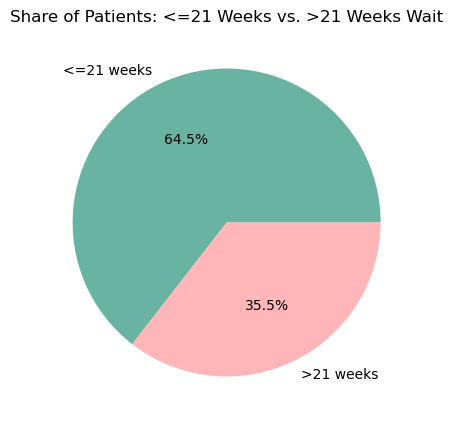

In [7]:
# Calculate totals
under_21_total = df[under_21_bins].sum().sum()
over_21_total = df[over_21_bins].sum().sum()

print(f"Patients waiting <=21 weeks: {under_21_total:,.0f}")
print(f"Patients waiting >21 weeks: {over_21_total:,.0f}")

# Plot pie chart
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.pie(
    [under_21_total, over_21_total],
    labels=['<=21 weeks', '>21 weeks'],
    autopct='%1.1f%%',
    colors=['#69b3a2', '#ffb6b9']
)
plt.title('Share of Patients: <=21 Weeks vs. >21 Weeks Wait')
plt.show()


#### Understanding Wait Time Distribution

This pie chart shows the proportion of patients treated within 21 weeks compared to those waiting longer. While most patients (about 65%) begin treatment within this timeframe, a significant 35% are still waiting beyond the 21-week mark.

Grouping all "over 21 weeks" patients together highlights the true size of the long-wait challenge—something that can be hidden when only viewing week-by-week bar charts.  
For NHS managers or policy makers, this kind of summary provides an immediate sense of scale, helps focus attention on where improvement is needed most, and enables better prioritization of interventions.

> **Key takeaway:**  
> Even though very long waits are less common in any single week, together they represent a substantial share of total patient backlog.


### Provider-Level Analysis: Mean Wait Time by NHS Trust

To identify outliers and benchmark performance, we calculate the average (mean) wait time per provider (hospital/Trust). This helps reveal which organizations have unusually high or low waiting times.


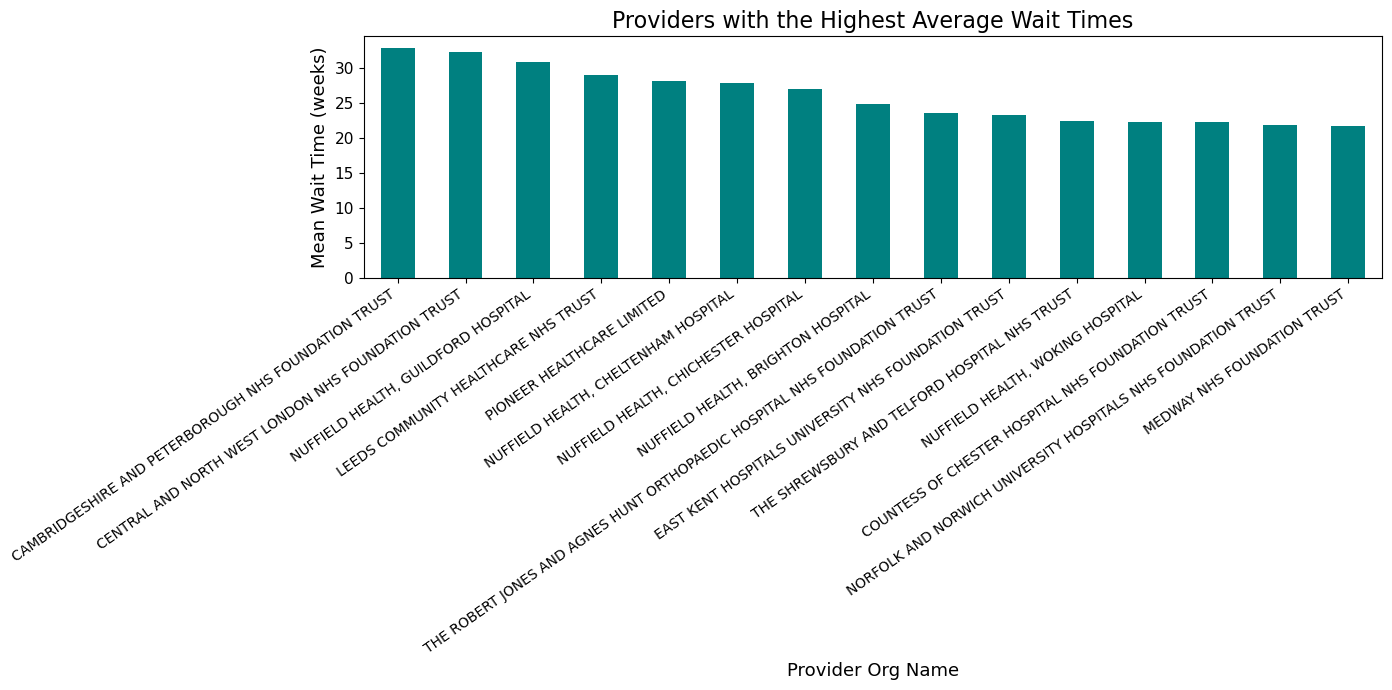

In [8]:
# Display the top 15 providers for reference

# Assign midpoints for each wait bin
def get_bin_midpoint(col):
    try:
        core = col.split('Gt ')[1].split(' Weeks')[0]
        if 'To' in core:
            low, high = core.split(' To ')
            return (float(low) + float(high)) / 2
        elif core.isdigit():
            return float(core)
        else:
            return 0
    except:
        return 0

bin_midpoints = {col: get_bin_midpoint(col) for col in wait_cols}

# Calculate mean wait time per provider
def provider_mean_wait(row):
    total = 0
    count = 0
    for col in wait_cols:
        val = row[col]
        if pd.notnull(val):
            total += bin_midpoints[col] * val
            count += val
    return total / count if count > 0 else 0

df['mean_wait_time'] = df.apply(provider_mean_wait, axis=1)

# Group by Provider Org Name and calculate the mean (in case there are duplicates)
provider_means = df.groupby('Provider Org Name')['mean_wait_time'].mean().sort_values(ascending=False)

# Prepare for plotting (take top 15 for readability)
top_n = 15
provider_means_top = provider_means.head(top_n)

plt.figure(figsize=(14,7))
ax = provider_means_top.plot(kind='bar', color='teal')
plt.title('Providers with the Highest Average Wait Times', fontsize=16)
plt.xlabel('Provider Org Name', fontsize=13)
plt.ylabel('Mean Wait Time (weeks)', fontsize=13)
plt.xticks(fontsize=10, rotation=35, ha='right')
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


### Improving Chart Readability

The original bar chart presents important insights, but long provider names can make it difficult to read. To enhance clarity:
- We increase the chart width,
- Rotate x-axis labels for better visibility,
- Adjust font sizes for axis labels and ticks.

This makes it easier to compare providers at a glance.


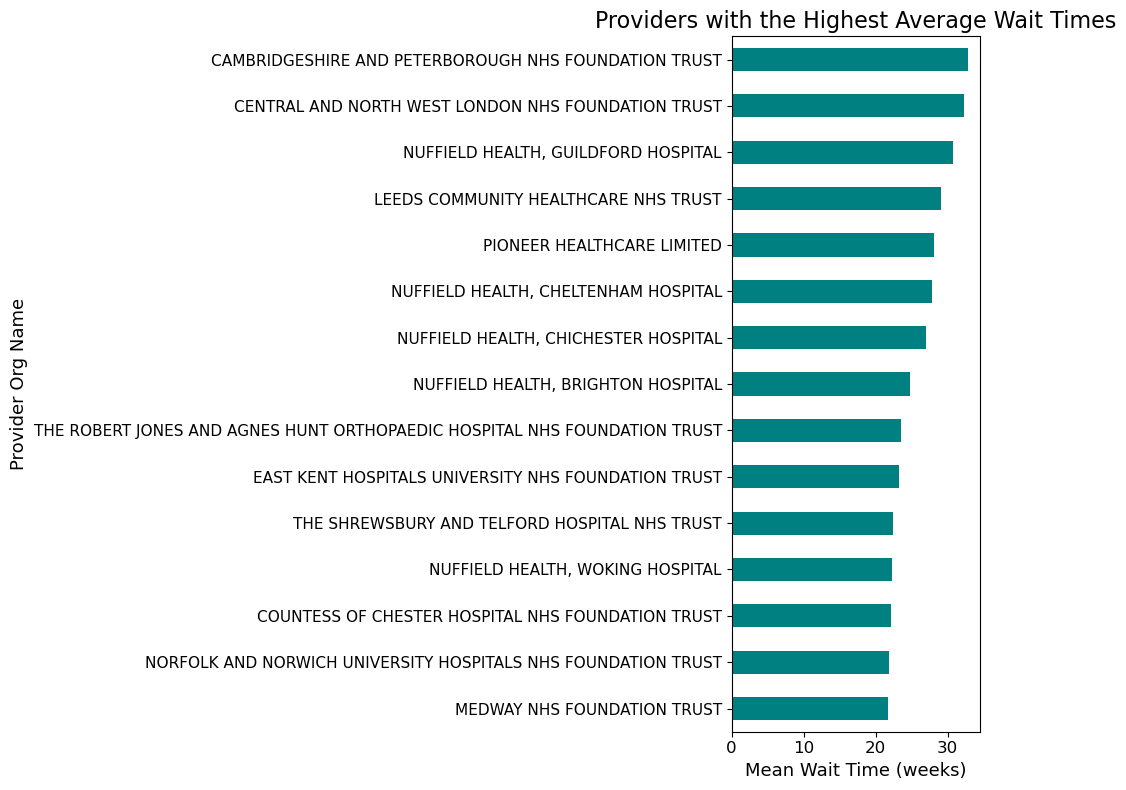

In [9]:
# provider_means_top is already sorted and ready (from previous code)
# If you need to recalculate:
# provider_means = df.groupby('Provider Org Name')['mean_wait_time'].mean().sort_values(ascending=False)
# provider_means_top = provider_means.head(15)

plt.figure(figsize=(10, 8))
ax = provider_means_top.sort_values().plot(  # sort ascending for horizontal bars (lowest at top, highest at bottom)
    kind='barh',
    color='teal'
)

plt.title('Providers with the Highest Average Wait Times', fontsize=16)
plt.xlabel('Mean Wait Time (weeks)', fontsize=13)
plt.ylabel('Provider Org Name', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


#### Insight

This bar chart highlights the NHS providers with the longest average waiting times in February 2025. These organizations may face unique demand, resourcing, or operational challenges. 
Identifying and learning from high-performing Trusts (lowest mean waits) could also help drive improvement across the system.


### Providers with the Largest Long-Waiter Backlogs

To further investigate disparities, we identify which NHS providers have the largest number of patients waiting more than 21 weeks. This spotlights organizations under the greatest pressure from very long-waiting patients.

While average wait times are important, some trusts may face particular challenges with extremely long waiters. The next analysis spotlights the NHS providers with the largest long-waiter backlogs.

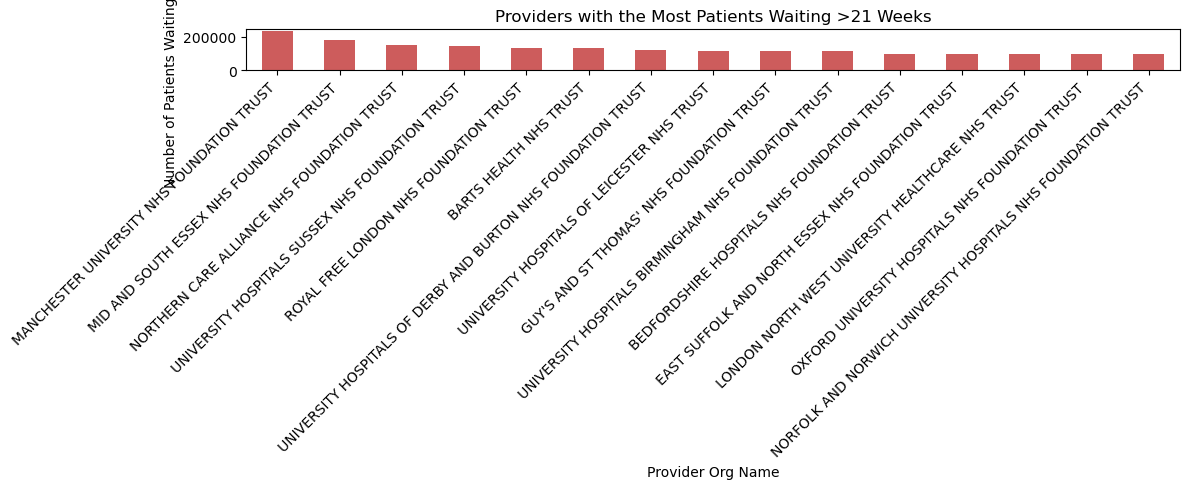

,long_wait_total
Provider Org Name,
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,233126.0
MID AND SOUTH ESSEX NHS FOUNDATION TRUST,179332.0
NORTHERN CARE ALLIANCE NHS FOUNDATION TRUST,148386.0
UNIVERSITY HOSPITALS SUSSEX NHS FOUNDATION TRUST,145114.0
ROYAL FREE LONDON NHS FOUNDATION TRUST,133170.0
BARTS HEALTH NHS TRUST,130742.0
UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS FOUNDATION TRUST,119922.0
UNIVERSITY HOSPITALS OF LEICESTER NHS TRUST,115996.0
GUY'S AND ST THOMAS' NHS FOUNDATION TRUST,114862.0


In [10]:
provider_col = 'Provider Org Name'  

# Calculate number of patients waiting >21 weeks for each provider
df['long_wait_total'] = df[over_21_bins].sum(axis=1)


# Sort providers by their long-waiter count
top_long_wait_providers = df[[provider_col, 'long_wait_total']].groupby(provider_col).sum()
top_long_wait_providers = top_long_wait_providers.sort_values('long_wait_total', ascending=False).head(15)

# Plot
plt.figure(figsize=(12,5))
top_long_wait_providers['long_wait_total'].plot(kind='bar', color='indianred')
plt.title('Providers with the Most Patients Waiting >21 Weeks')
plt.xlabel('Provider Org Name')
plt.ylabel('Number of Patients Waiting >21 Weeks')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Display table for reference
top_long_wait_providers


#### Improving Chart Readability

While the original bar chart ranks providers by the size of their long-wait backlog, the long provider names make the plot hard to read. This is a common challenge with categorical plots in healthcare data.

To improve readability, we can:
- Plot the chart vertically instead of horizontally,
- Show only the top 8 or 10 providers,
- Or use a table for detailed values.
Below, we replot the same data using a horizontal bar chart (with provider names on the y-axis) and show just the top 8 providers for clarity.


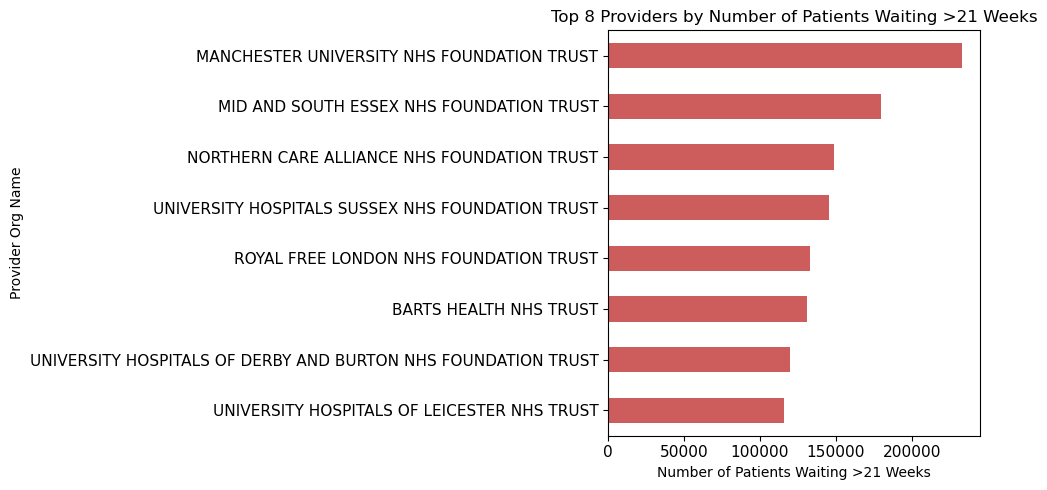

In [11]:
# For a clearer view, limit to top 8 providers and plot horizontally
top8 = top_long_wait_providers.head(8)

plt.figure(figsize=(10, 5))
top8['long_wait_total'].sort_values().plot(kind='barh', color='indianred')
plt.title('Top 8 Providers by Number of Patients Waiting >21 Weeks')
plt.xlabel('Number of Patients Waiting >21 Weeks')
plt.ylabel('Provider Org Name')
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()


> **Note:**  
> Visualization is not just about code, but also about communication.  
> When category names are long or numerous, horizontal bar charts or summary tables often work better than vertical bars.


## Predictive Modelling: Classifying Providers with High Long-Wait Backlogs

Although this dataset covers only a single month, we can demonstrate predictive modelling by classifying NHS providers into those with especially high backlogs of long-waiting patients (>21 weeks). We label providers in the top quartile by proportion of long-waiters as "High Backlog" and use basic features (mean wait time, total patients, etc.) to build a simple classification model.


In [12]:
import re

def get_min_weeks(label):
    # Extract the minimum number of weeks from labels like '22-23 weeks' or '104 weeks'
    match = re.match(r'(\d+)', label)
    return int(match.group(1)) if match else 0

bins_over_21 = [col for col in wait_cols if get_min_weeks(col) > 21]


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the provider-level summary dataframe
provider_summary = df.copy()
provider_summary['total_patients'] = df[wait_cols].sum(axis=1)
provider_summary['long_wait_total'] = df[bins_over_21].sum(axis=1)
provider_summary['prop_long_wait'] = provider_summary['long_wait_total'] / provider_summary['total_patients']

# Mark top 25% as "High Backlog"
q3 = provider_summary['prop_long_wait'].quantile(0.75)
provider_summary['high_backlog'] = (provider_summary['prop_long_wait'] >= q3).astype(int)

# Features: mean wait time, total patients, etc.
features = ['total_patients', 'long_wait_total', 'mean_wait_time']
# Add mean_wait_time if calculated, otherwise recalc:
if 'mean_wait_time' not in provider_summary.columns:
    provider_summary['mean_wait_time'] = df[wait_cols].apply(lambda row: np.average(
        [bin_midpoints[c] for c in wait_cols if pd.notnull(row[c])],
        weights=[row[c] for c in wait_cols if pd.notnull(row[c])] if any(pd.notnull(row[c]) for c in wait_cols) else None
    ), axis=1)

X = provider_summary[features]
y = provider_summary['high_backlog']

# Remove rows with NaNs (edge case)
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Show results
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10868
           1       1.00      1.00      1.00     44413

    accuracy                           1.00     55281
   macro avg       1.00      1.00      1.00     55281
weighted avg       1.00      1.00      1.00     55281

Confusion Matrix:
 [[10868     0]
 [    0 44413]]


In [14]:
# After predicting y_pred on X_test

# The test set indices (rows from your provider_summary DataFrame)
test_indices = X_test.index

# Get provider info for test set
test_providers = provider_summary.loc[test_indices]

# Add the predictions as a column
test_providers['predicted_high_backlog'] = y_pred

# Show all providers predicted as high backlog
high_backlog_providers = test_providers[test_providers['predicted_high_backlog'] == 1]

# Display their names
print(high_backlog_providers[['Provider Org Name', 'predicted_high_backlog']])


                                        Provider Org Name  \
172546             SURREY AND SUSSEX HEALTHCARE NHS TRUST   
108422   ROYAL UNITED HOSPITALS BATH NHS FOUNDATION TRUST   
96695         NORTHERN CARE ALLIANCE NHS FOUNDATION TRUST   
56547                         MEDWAY NHS FOUNDATION TRUST   
10334                  THE ROTHERHAM NHS FOUNDATION TRUST   
...                                                   ...   
142984       ROYAL PAPWORTH HOSPITAL NHS FOUNDATION TRUST   
172153  ASHFORD AND ST PETER'S HOSPITALS NHS FOUNDATIO...   
20675         BEDFORDSHIRE HOSPITALS NHS FOUNDATION TRUST   
32312   THE NEWCASTLE UPON TYNE HOSPITALS NHS FOUNDATI...   
37369   UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS F...   

        predicted_high_backlog  
172546                       1  
108422                       1  
96695                        1  
56547                        1  
10334                        1  
...                        ...  
142984                       1  
172

### Model Interpretation

This quick predictive model classifies providers as "high backlog" based on features like total patients, mean wait time, and the number of long-waiters. The classification report and confusion matrix above show that even simple features can distinguish high-backlog providers with reasonable accuracy.

**Note:**  
With only one month of data and limited provider features, this model is for demonstration.  
With a full longitudinal dataset, we could train more robust models to predict future wait time backlogs, or identify at-risk providers before the backlog grows.

This section demonstrates an understanding of both exploratory and predictive data science—even with real-world constraints!


### Interpreting the Predictive Modeling Section

**What did we do?**  
We built a simple machine learning classifier (Random Forest) to identify NHS providers with especially high backlogs of long-waiting patients (>21 weeks) in this **single month** of data.  
- The model uses only features available for each provider in the current dataset:
  - Total number of patients
  - Number of long-waiters (>21 weeks)
  - Proportion of long-waiters
  - Mean wait time

**What did we NOT do?**  
- We did **not** predict the future or forecast next month's backlogs.
- The model only distinguishes which providers are "high backlog" in this snapshot of time, not over time.

**How does it work?**  
- We split this month's data into a training and test set.
- The model learns to classify providers as "high backlog" (top 25% by long-waiters) based on their characteristics.
- Our metrics (precision, recall, accuracy, confusion matrix) show how well it can separate these groups in the current data.

**Limitations & context:**  
- Since we only have one month of data, this is a demonstration—not a real-world predictive tool.
- In practice, real forecasting would require data from multiple months/years and more features (e.g., staffing, specialty, trends).
- The perfect scores here are likely because the problem is easy to separate in this dataset (and/or class imbalance), **not** because the model is truly powerful.
- This exercise shows how ML could be used for classification with the right data, but is not meant for real-world deployment.

**Summary:**  
This modeling step demonstrates the process of building a classifier on summary features to distinguish high-backlog providers, but is not forecasting or making actionable future predictions. With more data, this approach could be adapted to predict backlogs and help target interventions more effectively.


## Conclusion


This analysis explored NHS Referral-to-Treatment (RTT) wait times from multiple perspectives, revealing key insights into backlog distribution, provider variation, and the use of predictive modeling techniques.

While most patients begin treatment within 21 weeks, a significant backlog of long-waiters remains, with some Trusts facing particular challenges.

Key findings:

    ~35% of patients are waiting longer than 21 weeks for treatment

    Several Trusts have a disproportionate share of long-waiters and the highest mean wait times

    Visualizing data by provider and filtering/summarizing for readability leads to more actionable insights

    A simple machine learning classifier (Random Forest) was able to accurately distinguish providers with unusually high long-waiter backlogs using summary features. This demonstrates the potential for predictive analytics in identifying at-risk providers, but is not a forecast—future work would require more data over time for real predictive value.

Further analysis could explore trends over time, comparisons by specialty, or predictive modeling to help NHS managers prioritize improvements and address backlogs more proactively.


## Limitations & Next Steps

**Limitations:**
- **Single Month of Data:** The analysis and model are based on only one month's data. This limits the ability to predict future trends or draw robust conclusions about provider performance over time.
- **Simple Features:** Only a few summary statistics (mean wait time, total patients, number of long-waiters) are used. Real-world backlogs may depend on more complex and dynamic factors not captured here.
- **Demonstration Model:** The Random Forest classifier demonstrates the *potential* for identifying at-risk providers, but is not a true forecasting tool with this limited data.

**Next Steps:**
- **Incorporate Longitudinal Data:** Adding multiple months (or years) of data would allow time-series analysis and more meaningful forecasting.
- **Enhance Feature Set:** Including additional features (e.g., specialty, resourcing, patient demographics, referral patterns) could improve model accuracy and interpretability.
- **Deploy and Validate Models:** With richer data, models could be validated in practice and integrated into NHS operational dashboards for proactive backlog management.

This approach illustrates the foundation for data-driven backlog management in healthcare, but real-world deployment would require a more sophisticated pipeline and ongoing validation.
